# FashionMNIST Image Classification

## Importing important libraries

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL
import torch
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

 ## Load FashionMNIST dataset

In [2]:
# Ensure that the current current PyTorch installation was built with MPS activated
torch.backends.mps.is_built()

True

In [3]:
# Device configuration
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f'Using device: {device}')

Using device: mps


If GPU is available, use it for computation, otherwise use CPU

In [4]:
# Download built-in FashionMNIST dataset from torchvision module 
train_set = torchvision.datasets.FashionMNIST(
    "./data", download = True, 
    transform = transforms.Compose([transforms.ToTensor()])) # load training set

test_set = torchvision.datasets.FashionMNIST(
    "./data", download = True, train = False, 
    transform = transforms.Compose([transforms.ToTensor()])) # load test set

`transforms.ToTensor` is a function/transform that converts a `PIL image` (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or a `numpy.ndarray` (H x W x C) in the range $[0, 255]$ to a `torch.FloatTensor` of shape (C x H x W) in the range $[0.0, 1.0]$.

In [6]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 100)

`torch.utils.data.DataLoader()` is a data loading utility. 



## Explore the data
### 1. Dataset

In [8]:
# number of images in our training set
len(train_set)

60000

In [9]:
# label tensor
train_set.train_labels

/Users/uu/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([9, 0, 0,  ..., 3, 0, 5])

The values $[9, 0, 0,  ..., 3, 0, 5]$ encode actual class names of our labels.

For instance, $9$ reprensents an ankle boot, $0$ represents a t-shirt/top, and so on.


In [10]:
# frequency of each value within a tensor
train_set.train_labels.bincount()

tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

`.bincount()` returns the frequency distribution of the values inside a tensor.
Here the fMINIST dataset is uniformly distributed wrt the number of samples from each class.

In [11]:
sample = next(iter(train_set)) # access to an individual element from a train_set object
len(sample) # length of a sample

2

- `iter()` returns an object representing a stream of data 
- `next()` gets the next data element from the data stream
- length of a sample is 2 because each sample contains an `image, label` pair, where image is a tensor and label is also a tensor 

In [12]:
image, label = sample # sequence/list unpacking
image.shape 

torch.Size([1, 28, 28])

While RBG images have 3 color channels, grey-scale images have a single color channel. Since fMNIST contains greyscale images, we are dealing with a single color channel with $height = 28$ and $width = 28$

In [13]:
# matrix of pixels of the first image
image[0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510, 0.2863, 0.0000,
         0.0000, 0.0039, 0.0157, 0.0000, 0.0000, 0.0000

In [14]:
# first row of pixels of the first image
image[0][0] 

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

### 2. DataLoader

In [15]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size = 10)
batch = next(iter(demo_loader))
images, labels = batch

In [16]:
images.shape

torch.Size([10, 1, 28, 28])

- `images` is a rank 4 tensor
- Its parameters tell us that we have 10 images that have a single color channel, with the height and width of 28

In [17]:
labels.shape

torch.Size([10])

- `labels` is a rank 1 tensor whose single axis has a length of 100. 
- This axis contains labels, one for each of the 10 images in our batch.

In [18]:
images[0] # matrix of pixels for a batch of 10 images

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [19]:
images[0][0] # matrix of pixels for the first image in the first batch

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510, 0.2863, 0.0000,
         0.0000, 0.0039, 0.0157, 0.0000, 0.0000, 0.0000

### 3. Some example images

9


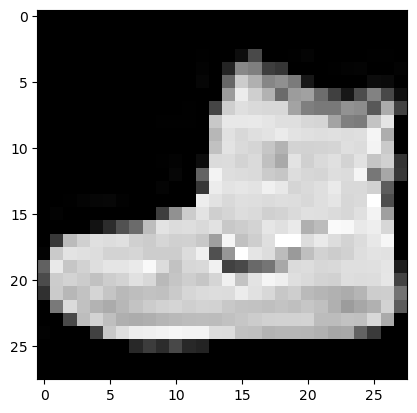

In [22]:
# Show one image input
plt.imshow(image.squeeze(), cmap = "gray")
print(label)

In [23]:
def output_label(label):
    '''
    return label mappings to each of the class name"
    '''
    output_mapping = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneakers",
        8: "Bag",
        9: "Ankle Boot"
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

labels:  Ankle Boot, T-shirt/top, T-shirt/top, Dress, T-shirt/top, Pullover, Sneakers, Pullover, Sandal, Sandal, 

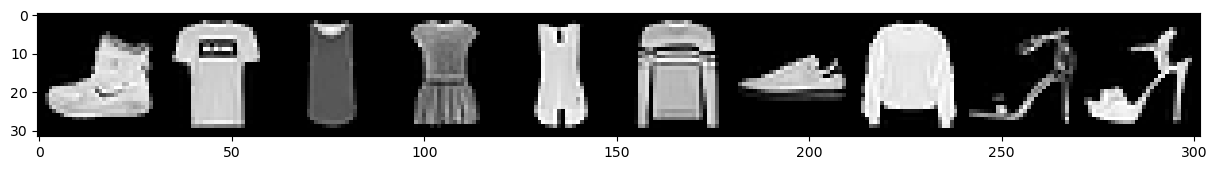

In [26]:
grid = torchvision.utils.make_grid(images, nrow = 10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(output_label(label), end=", ") 

## Normalization

In [27]:
n_samples_seen = 0.
mean = 0
std = 0
for train_batch, train_target in train_loader:
    batch_size = train_batch.shape[0]
    train_batch = train_batch.view(batch_size, -1)
    this_mean = torch.mean(train_batch, dim=1)
    this_std = torch.sqrt(
        torch.mean((train_batch - this_mean[:, None]) ** 2, dim=1))
    mean += torch.sum(this_mean, dim=0)
    std += torch.sum(this_std, dim=0)
    n_samples_seen += batch_size

mean /= n_samples_seen
std /= n_samples_seen

print(mean, std)

tensor(0.2860) tensor(0.3202)


## Data Augmentation 

In [30]:
# List of transformations applied to train set
training_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.2),
    torchvision.transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2),
    torchvision.transforms.Resize(size=(32, 32)),
    torchvision.transforms.RandomCrop(size=(28, 28)),
    torchvision.transforms.RandomRotation(degrees=10, interpolation=PIL.Image.BILINEAR),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.2860,), std=(0.3202,)),
])

# List of transformations applied to test set
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.2860,), std=(0.3202,)),
])

/var/folders/_g/s_f5l5_d74q8f_sp5rx78mhw0000gn/T/ipykernel_3056/3854419840.py:8: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  torchvision.transforms.RandomRotation(degrees=10, interpolation=PIL.Image.BILINEAR),
/Users/uu/opt/anaconda3/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1305: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(



Transformations options

1. `RandomHorizontalFlip()`: horizontally flip the given image randomly with a given probability
2. `Resize()`: crop a random portion of image and resize it to a given size
3. `RandomCrop()`: crop the given image at a random location
4. `RandomRotation()`: rotate an image by an angle, interpolation method used is bilinear
5. `ToTensor()`: transform PIL image to tensor
6. `Normalize()`: normalize data $\frac{x_i-\bar{x}}{std}$, if images are $[0, 1]$, they will be $[-1, 1]$ afterwards


In [31]:
# Apply transformations to data 
# Load the train_set, test_set, train_loader, and test_loader

train_set = datasets.FashionMNIST(root='data', 
                               train=True, 
                               transform=training_transforms,
                               download=True)

test_set = datasets.FashionMNIST(root='data', 
                              train=False, 
                              transform=test_transforms)


train_loader = DataLoader(dataset=train_set, 
                          batch_size=100, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_set, 
                         batch_size=100, 
                         shuffle=False)

## Explored the preprocessed data

In [32]:
# Revisit out train set after transforming our train_set
sample = next(iter(train_set)) 
image, label = sample 
image.shape 

torch.Size([1, 28, 28])

In [33]:
# first row of pixels of the first image after augmentation
image[0][0] 

tensor([-0.8932, -0.8932, -0.8932, -0.8932, -0.8932, -0.8932, -0.8932, -0.8932,
        -0.8687, -0.8687, -0.8687, -0.8687, -0.8687, -0.8687, -0.8687, -0.8687,
        -0.8687, -0.8687, -0.8687, -0.8687, -0.8687, -0.8687, -0.8687, -0.8687,
        -0.8687, -0.8687, -0.8687, -0.8932])

In [34]:
# Revisit our train loade after trainsforming our data
demo_loader = torch.utils.data.DataLoader(train_set, batch_size = 10)
batch = next(iter(demo_loader))
images, labels = batch
images.shape

torch.Size([10, 1, 28, 28])

In [35]:
images[0][0][0] # first row of pizxels for the first image in the first batch

tensor([-0.8932, -0.8932, -0.8932, -0.8932, -0.8932, -0.8932, -0.8932, -0.8932,
        -0.8932, -0.8932, -0.8932, -0.8932, -0.8932, -0.8932, -0.8932, -0.8932,
        -0.8932, -0.8932, -0.8932, -0.8932, -0.8932, -0.8932, -0.8932, -0.8932,
        -0.8932, -0.8932, -0.8932, -0.8932])

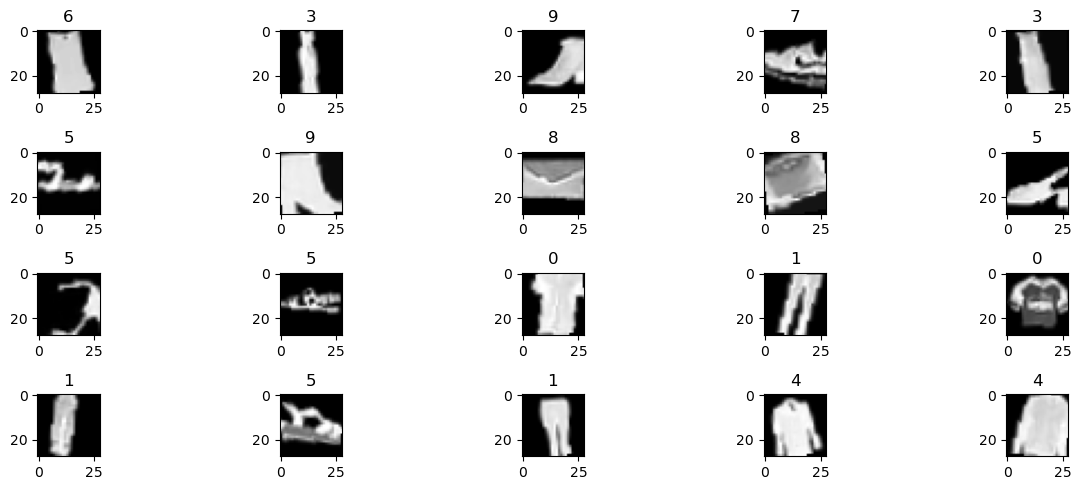

In [36]:
# Display augmented image inputs along with their corresponding labels
import matplotlib.pyplot as plt 
%matplotlib inline

dataiter = iter(train_loader)
print(dataiter)
images, labels = dataiter.next()

fig = plt.figure(figsize = (15, 5))

for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx + 1) 
    ax.imshow(np.squeeze(images[idx]), cmap = 'gray')
    # np.squeeze: remove single-dimensional entries from the shape of an array    
    ax.set_title(labels[idx].item())
    # .item() gets the value contained in a Tensor
    fig.tight_layout()